In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import math

In [2]:
test_run = 2

In [3]:
class Model(nn.Module):
    def __init__(self, input_num: int, layers: list[int], dropout_p: float = 0.5):
        super(Model, self).__init__()

        layers_list = []

        in_num = input_num
        for i in layers:
            layers_list.append(nn.Linear(in_num, i))
            layers_list.append(nn.ReLU(inplace=True))
            layers_list.append(nn.BatchNorm1d(i))
            layers_list.append(nn.Dropout(dropout_p))
            in_num = i

        layers_list.append(nn.Linear(layers[-1], 1))
        self.layers = nn.Sequential(*layers_list)

    def forward(self, x):
        x = self.layers(x)
        return x

In [4]:
data = pd.read_csv('House_Rent_Dataset.csv')

In [5]:
data.drop(columns='Area Locality', inplace=True)
data.drop(columns='Posted On', inplace=True)
data["Total Floors"] = data["Floor"].apply(lambda floor: floor.split()[-1]).replace('Ground', 1)
data["Floor"] = (data["Floor"].apply(lambda floor: floor.split()[0])
                     .replace('Ground', 0)
                     .replace('Upper', 99)
                     .replace('Lower', -1)).astype("int64")

data = pd.get_dummies(data, columns=['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of '
                                                                                                       'Contact'])

In [80]:
X = data.drop(columns='Rent', axis=1).astype('float32')
y = data['Rent'].astype("int64")

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=77)

X_train = torch.FloatTensor(X_train.to_numpy())
X_val = torch.FloatTensor(X_val.to_numpy())
X_test = torch.FloatTensor(X_test.to_numpy())
y_train = torch.FloatTensor(y_train.to_numpy()).reshape(-1,1)
y_test = torch.FloatTensor(y_test.to_numpy()).reshape(-1,1)
y_val = torch.FloatTensor(y_val.to_numpy()).reshape(-1,1)

In [174]:
torch.manual_seed(77)
model = Model(X.shape[1], [200, 100, 50], 0.4)

In [175]:
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)

In [176]:
epochs = 2000
losses = []
diffs = []
start_time = time.time()
for i in range(epochs):
    i += 1
    model.train()
#    X_train, y_train = train_dataset.dataset.tensors
    y_pred = model(X_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    loss = 0.0
    with torch.no_grad():
#        X_val, y_val = val_dataset.dataset.tensors
        y_pred = model(X_val)
        loss = torch.sqrt(criterion(y_pred, y_val))
    losses.append(loss.item())
    if i % 50 == 0:
        print(f"Epoch ({i:3}): Loss: {losses[-1]:10.5f}")

print(f"Training duration: {time.time() - start_time:.2f} seconds")

Epoch ( 50): Loss: 80876.24219
Epoch (100): Loss: 80786.31250
Epoch (150): Loss: 80707.65625
Epoch (200): Loss: 80474.44531
Epoch (250): Loss: 80364.09375
Epoch (300): Loss: 79957.86719
Epoch (350): Loss: 79686.03125
Epoch (400): Loss: 79548.61719
Epoch (450): Loss: 78921.87500
Epoch (500): Loss: 78629.35938
Epoch (550): Loss: 78610.61719
Epoch (600): Loss: 77885.76562
Epoch (650): Loss: 76576.13281
Epoch (700): Loss: 77525.96094
Epoch (750): Loss: 75273.70312
Epoch (800): Loss: 74336.44531
Epoch (850): Loss: 74988.07031
Epoch (900): Loss: 73084.61719
Epoch (950): Loss: 73767.75000
Epoch (1000): Loss: 70786.71094
Epoch (1050): Loss: 70885.12500
Epoch (1100): Loss: 69908.39844
Epoch (1150): Loss: 70480.46875
Epoch (1200): Loss: 67741.46875
Epoch (1250): Loss: 67776.14062
Epoch (1300): Loss: 66883.59375
Epoch (1350): Loss: 66109.68750
Epoch (1400): Loss: 64589.94922
Epoch (1450): Loss: 63236.08594
Epoch (1500): Loss: 63923.76172
Epoch (1550): Loss: 61856.63281
Epoch (1600): Loss: 60096.8

In [161]:
model.eval()
criterion = nn.L1Loss(reduction="sum")
with torch.no_grad():
#    X_train, y_train = train_dataset.dataset.tensors
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    print(f"Train średni błąd: {(loss / len(X_train)):4.3f}, Błąd względny: {loss * 100/ torch.sum(y_train):4.3f} %")

Train średni błąd: 10079.220, Błąd względny: 30.799 %


In [162]:
model.eval()
criterion = nn.L1Loss(reduction="sum")
with torch.no_grad():
#    X_val, y_val = val_dataset.dataset.tensors
    y_pred = model.forward(X_val)
    loss = criterion(y_pred, y_val)
    print(f"Validation średni błąd: {(loss / len(X_val)):4.3f}, Błąd względny: {loss * 100/ torch.sum(y_val):4.3f} %")

Validation średni błąd: 13999.141, Błąd względny: 38.571 %


In [163]:
model.eval()
criterion = nn.L1Loss(reduction="sum")
with torch.no_grad():
#    X_test, y_test= test_dataset.dataset.tensors
    y_pred = model.forward(X_test)
    loss = criterion(y_pred, y_test)
    print(f"Test średni błąd: {(loss / len(X_test)):4.3f}, Błąd względny: {loss * 100/ torch.sum(y_test):4.3f} %")

Test średni błąd: 17251.678, Błąd względny: 38.967 %


Text(0.5, 0, 'epoch')

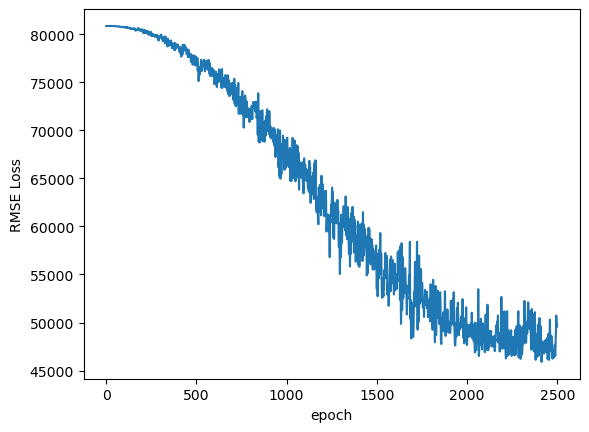

In [95]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

In [16]:
torch.save(model.state_dict(), f'Model_{test_run}.pt')